# Comparisson with Conv1D-LSTM Networks - Bearing Dataset


## Imports

In [394]:
from collections import OrderedDict

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalAveragePooling1D, Dropout
from tensorflow.keras import Sequential,Model
import tensorflow.keras as keras

config = ConfigProto()
config.gpu_options.allow_growth = True

# for no GPU:
sess = InteractiveSession(config=config)

import numpy as np
import matplotlib.pyplot as pplot
tfd = tfp.distributions
from ipywidgets import FloatSlider, IntSlider, interact, interactive

import pandas as pd


/home/charilaos/.local/lib/python3.8/site-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [395]:
from datasets.fictitious_dataset import FictitiousDataset
fic =  FictitiousDataset(n_exp_per_case=5,pct_val_set=0.12,)
fic_test =  FictitiousDataset(n_exp_per_case=1,pct_val_set=0.12,)


Created random data for fictitious experiment.
training experiments: 12 , testing 3
Created random data for fictitious experiment.
training experiments: 0 , testing 3


# Load data

In [396]:
def get_multi_batch_fictitious(*args, **kwargs):
    new_args = (args[0], fic)
    return get_multi_batch(*new_args, **kwargs)

def get_multi_batch_bootstrap_fictitious(*args,**kwargs):
    new_args = (args[0], fic)
    kwargs.update({"full_past_params" : {"min_idx_last_node" : 100 }})
    return get_multi_batch(*new_args,**kwargs)

In **GraphNets** I cannot simply randomly sample from different experiments. I need some code to make graph inputs for this dataset.

In [397]:
from utils import get_graph_data


# LSTM Implementation

# Conv1D LSTM

In [398]:
from graphnet_utils import GraphNetFunctionFactory
gn = GraphNetFunctionFactory()
make_conv_input_head_node_function = lambda edge_size , **kwargs: gn.make_conv_input_head_node_function(edge_size, **kwargs)
make_node_function = lambda *args, **kwargs : gn.make_node_function(*args,**kwargs)
make_edge_function_gi = lambda *args , **kwargs : gn.make_edge_function_gi
make_gamma_node_observation_mlp = lambda *args,**kwargs : gn.make_gamma_node_observation_mlp(*args , **kwargs)

In [399]:
help(gn.make_gamma_node_observation_mlp)

Help on method make_gamma_node_observation_mlp in module graphnet_utils:

make_gamma_node_observation_mlp(n_node_state_output) method of graphnet_utils.GraphNetFunctionFactory instance
    Takes as input a node state and returns a gamma probability distribution



In [400]:
gg = [g[0] for g in graph_dat_multibatch]
g = gg[0]

In [401]:
np.all(np.apply_along_axis(lambda  x : x == [[10,1,1]],1,np.array([e.edge_tensor.shape  for e in g.edges]) ))

True

In [402]:
np.stack([e.edge_tensor for e in g.edges]).shape

(1225, 10, 1, 1)

# Training

In [403]:
# ok - keep
from src.convlstm import Conv1DLSTMCell

from utils import get_multi_batch

#DATASET = femto_dataset
DATASET = fic

def graph_dat_to_rnn_dat(graph_dat_, edge_feat_size = None):
    node_feats = np.transpose(np.stack([n.node_attr_tensor for n in  graph_dat_.nodes]),[1,0,2,3])
    
    nodes = graph_dat_.nodes
    batch_size = nodes[0].shape[0];
    
    all_edges = graph_dat_.edges
    if edge_feat_size is None:
        if len(all_edges)>0:
            edge_feat_size = all_edges[0].edge_tensor.shape[1]
        else:
            print("You need to specify edge feature size in order to specify RNN cells from graph data!")
        
    
    fo_edges = []
    #fo_edges.append(np.zeros_like(graph_dat_.edges[0].edge_tensor))
    
    # The first edge is dummy.
    fo_edges.append(np.zeros([batch_size,1,edge_feat_size]))
    if len(all_edges) != 0:
        for ni in range(len(nodes)):
            for e in all_edges:
                # checks if the edge has consecutive nodes:
                if ( e.node_from is nodes[ni]) and (e.node_to is nodes[ni+1]): 
                    fo_edges.append(e.edge_tensor)
                    
#     try:
    edge_feats = np.transpose(np.stack(fo_edges),[1,0,2,3])

    return node_feats, edge_feats
#     except:
#         print("SOMETHING WRONG!")
#         return fo_edges

def graph_multibatch_to_rnn_multibatch(graph_dat_multibatch_, edge_feat_size = None):
    """
    Returns tensors for sampled timepoints from a dataset.
    changes the format assumed in the graph example so that it is compatible with Keras/TF RNNs.
    """
    
    lstm_dat_input = [];
    lstm_dat_y = [dt[1] for dt in graph_dat_multibatch_]; # that dt[1] object is the RUL (second element of each tuple in the multibatch)
    
    
    
    for g in graph_dat_multibatch:
        lstm_dat_input.append(graph_dat_to_rnn_dat(g[0], edge_feat_size = edge_feat_size))
        
    return lstm_dat_input,lstm_dat_y
    
    

def get_multi_batch_local(*args, **kwargs):
    new_args = (args[0], DATASET)
    return get_multi_batch(*new_args, **kwargs)

def get_multi_batch_rnn(*args, **kwargs):
    edge_feat_size = kwargs['edge_feat_size']
    del kwargs['edge_feat_size']
    graph_dat_     = get_multi_batch_local(*args, **kwargs)
    if edge_feat_size is None and nnodes == 1:
        print("You need to specify the size of the edge inputs for RNNs with single nodes (cannot be inferred)!")
        assert(0)
        
    lstm_dat_input = [];
    lstm_dat_y = [dt[1] for dt in graph_dat_];

    for g in graph_dat_:
        
        lstm_dat_input.append(graph_dat_to_rnn_dat(g[0], edge_feat_size = edge_feat_size))

    return (lstm_dat_input, lstm_dat_y)
        
    #graph_to_rnn_ = graph_multibatch_to_rnn_multibatch(graph_dat, edge_feat_size = edge_feat_size)
    #return graph_to_rnn_
    
    

In [404]:
graph_dat_multibatch = get_multi_batch_local(10, nseq_range=150, nnodes = 50, min_spacing=1)


In [405]:
#[e.edge_tensor for e in graph_dat_multibatch[0][0].edges]
e = graph_dat_multibatch[0][0].edges[0]
e.edge_tensor.shape

(10, 1, 1)

In [406]:
max_seq_length = [np.sum(fic.eid==e) for e in np.unique(fic.eid)]

In [407]:
graph_dat_multibatch[0][0].edges[0].edge_tensor.shape

(10, 1, 1)

In [408]:

# ok keep
nbatch = 2
nnodes = 5
# graph_dat_multibatch = get_multi_batch_local(10, nseq_range=150, nnodes = nnodes, min_spacing=1)

# lstm_dat_input = [];
# edge_feat_size  = 1 
# lstm_dat_y = [dt[1] for dt in graph_dat_multibatch];

# for g in graph_dat_multibatch:
#     lstm_dat_input.append(graph_dat_to_rnn_dat(g[0], edge_feat_size = edge_feat_size))

curr_data, y_curr_data = get_multi_batch_rnn(nbatch,
                                             source_ds=True,
                                             nnodes = nnodes,
                                             edge_feat_size=1,
                                             nseq_range= 150, min_spacing = 1)

In [409]:
curr_data[0][0].shape, y_curr_data[0].shape


((2, 5, 1000, 1), (2, 1))

In [410]:
#[c.shape for c in curr_data]
#[c.shape for c in y_curr_data]


In [411]:
from graphnet_utils import GraphNetFunctionFactory


In [412]:
import src.convlstm as clstm
ksize = 3;
nfilts = 18;
nfilts2 = 50

p=[{"type"  : "input"    , "kwargs" : {"shape" : (None,1)}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : 1,    "filters" : nfilts2,    "strides" : 1, "use_bias" : False, "name" : "conv_fcnA"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2, "use_bias" : False, "name" : "conv_fcnB"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2,"activation":"relu", "use_bias" : False, "name" : "conv_fcnC"}},
 {"type" : "dropout"   ,"kwargs":{"rate" : 0.2}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,    "filters" : nfilts2,    "strides" : 2, "use_bias" : False, "name" : "conv_fcnD"}},
 {"type" : "avg_pool1d", "kwargs":{"pool_size" : 2}},

#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : 1,    "filters" : nfilts2,    "strides" : 1, "use_bias" : False, "name" : "conv_fcnA2"}},
#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2, "use_bias" : False, "name" : "conv_fcnB2"}},
#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2,"activation":"relu", "use_bias" : False, "name" : "conv_fcnC2"}},
#  {"type" : "dropout"   ,"kwargs":{"rate" : 0.2}},
#  {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,    "filters" : nfilts2,    "strides" : 2, "use_bias" : False, "name" : "conv_fcnD2"}},
#  {"type" : "avg_pool1d", "kwargs":{"pool_size" : 2}},
   
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : 1,    "filters" : nfilts2,    "strides" : 1, "use_bias" : False, "name" : "conv_fcnA3"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2, "use_bias" : False, "name" : "conv_fcnB3"}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,"filters" : nfilts, "strides" : 2,"activation":"relu", "use_bias" : False, "name" : "conv_fcnC3"}},
 {"type" : "dropout"   ,"kwargs":{"rate" : 0.2}},
 {"type" : "conv1d"    ,"kwargs":{"kernel_size" : ksize,    "filters" : nfilts2,    "strides" : 2, "use_bias" : False, "name" : "conv_fcnD3"}},
 {"type" : "global_average_pooling", "kwargs":{}},
 {"type" : "dense" , "kwargs" : {"units" : 20,"use_bias" : False}}]

head_dt = [{"type" : "input", "kwargs" : {"shape" : (1,)}},
                   {"type" : "dense" , "kwargs" : {"units" : 20, "use_bias" : False}}];




In [413]:
# cnn_head = make_cnn_head()

# Model Creation

In [414]:
nstate = 30
cell_ = Conv1DLSTMCell(nstate, dt_model_params=head_dt, cnn_model_params=p)
# cell_.build((None,1), (None,None,2))
cell_.build((None,1), (None,None,1)) # for simulated dataset (only one channel)


here...
{'type': 'input', 'kwargs': DictWrapper({'shape': (None, 1)})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 1, 'filters': 50, 'strides': 1, 'use_bias': False, 'name': 'conv_fcnA'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnB'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'activation': 'relu', 'use_bias': False, 'name': 'conv_fcnC'})}
{'type': 'dropout', 'kwargs': DictWrapper({'rate': 0.2})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 50, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnD'})}
{'type': 'avg_pool1d', 'kwargs': DictWrapper({'pool_size': 2})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 1, 'filters': 50, 'strides': 1, 'use_bias': False, 'name': 'conv_fcnA3'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnB3'}

In [415]:
from src.convlstm import make_layer,make_seq

#network_size_global = 50;
nstate = 30 # or 30

MAKE_WITH_FACTORY = False;

if MAKE_WITH_FACTORY:
    def make_cnn_head(name = None):
        kwparams = {
            "output_size"  : nstate,
            "n_conv_blocks" :  3,
            "nfilts" :  18,
            "nfilts2" : 50,
            "ksize" : 3,
            "activation_type" :  "leaky_relu",
            "channels_in" :  1,
        }
        edge_dummy_size = 123
        # The following makes  a cnn model corresponding to a well performing GN-CNN model (the proposed alternative).
        cnn_model = GraphNetFunctionFactory.make_conv_input_head_node_function(None,edge_dummy_size,**kwparams)
        yout = cnn_model.output
        timeseries_input = [i for i in cnn_model.inputs if 'timeseries_input' in i.name][0]
        return tf.keras.Model(inputs = timeseries_input, outputs = yout, name = name)


    #make_seq(p, name = "name")
    cell = Conv1DLSTMCell(nstate, dt_model_params=head_dt, cnn_model_params=None, conv_factory = make_cnn_head)
else:
     cell = Conv1DLSTMCell(nstate, dt_model_params=head_dt, cnn_model_params=p)
    

nchannels = 1
cell.build((None,1), (None,None,nchannels))
rnn = tf.keras.layers.RNN(cell)

x_in = Input(shape = (None,1))
x_in_ts = Input( shape = (None,None, nchannels))

y_out = rnn((x_in,x_in_ts))
n_node_state_output = int(rnn.output.shape[-1])

gamma_out_mlp = make_gamma_node_observation_mlp(n_node_state_output)
y_out = gamma_out_mlp(y_out)
rnn_gamma_model = Model(inputs = [x_in, x_in_ts] , outputs = y_out)


here...
{'type': 'input', 'kwargs': DictWrapper({'shape': (None, 1)})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 1, 'filters': 50, 'strides': 1, 'use_bias': False, 'name': 'conv_fcnA'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnB'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'activation': 'relu', 'use_bias': False, 'name': 'conv_fcnC'})}
{'type': 'dropout', 'kwargs': DictWrapper({'rate': 0.2})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 50, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnD'})}
{'type': 'avg_pool1d', 'kwargs': DictWrapper({'pool_size': 2})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 1, 'filters': 50, 'strides': 1, 'use_bias': False, 'name': 'conv_fcnA3'})}
{'type': 'conv1d', 'kwargs': DictWrapper({'kernel_size': 3, 'filters': 18, 'strides': 2, 'use_bias': False, 'name': 'conv_fcnB3'}

In [416]:
rnn_gamma_model.inputs, n_node_state_output

([<KerasTensor: shape=(None, None, 1) dtype=float32 (created by layer 'input_48')>,
  <KerasTensor: shape=(None, None, None, 1) dtype=float32 (created by layer 'input_49')>],
 30)

In [417]:
inds_exp_source = DATASET.inds_exp_source
inds_exp_target = DATASET.inds_exp_target
X = DATASET.X
yrem_norm = DATASET.yrem_norm
eid_oh = DATASET.eid_oh

## Adaptation from the GraphCNN version:

In [418]:
from tqdm import tqdm


In [419]:
class LossLogger:
    def __init__(self):
        self.losses  = ["loss", "val_loss"]
        self.loss_history = {k:[] for k in self.losses}
    def append_loss(self, loss_):
        self.loss_history['loss'].append(loss_)
        
    def append_val_loss(self, val_loss_):
        self.loss_history['val_loss'].append(val_loss_)
    
    def print(self):
        loss, val_loss = [self.loss_history[vv] for vv in self.losses]
        print("loss: %2.3f, val_loss %2.3f"%(loss[-1], val_loss[-1]))

class EarlyStopping:
    def __init__(self, patience, loss_handle):
        self.patience = patience
        self.loss_handle = loss_handle
    
    def on_epoch_end(self, epoch):
        break_ = False
        
        if len(self.loss_handle) > 1:
            if np.all(np.min(self.loss_handle[-self.patience:]) > self.min_val):
                print("*** Early stopping. ***")
                break_ = True
                
            else:
                self.min_val = np.min(self.loss_handle)
        else:
            
            self.min_val = self.loss_handle[-1]
        
        return break_
    
class LRScheduler:
    def __init__(self, opt_object, epoch_decay = 50, decay_rate = 0.95):
        self.opt_object = opt_object
        self.epoch_decay = epoch_decay
        self.decay_rate = decay_rate
        
    def on_epoch_end(self,epoch):
        if epoch >= self.epoch_decay:
            lr = self.opt_object.lr.numpy()
            new_lr = lr * self.decay_rate
            print("setting lr to %2.3f"%new_lr)
            self.opt_object.lr.assign(new_lr)
        

In [420]:
learning_rate = 0.001;
opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_log = LossLogger()
early_stop = EarlyStopping(50,loss_log.loss_history['val_loss'])
lr_scheduler = LRScheduler(opt, epoch_decay = 60, decay_rate = 0.99)

## Training loop for the Long-term CNN model
The loop is structured almost identically as the corresponding GraphNet loop.

  0%|          | 0/200 [00:00<?, ?it/s]

nnodes: 1, seq_range 2 epoch: 0
loss: 284.635, val_loss 11.385


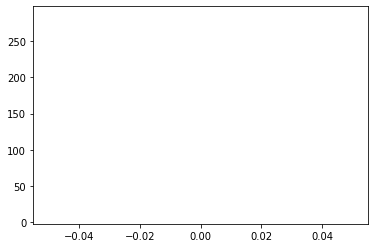

  0%|          | 1/200 [00:00<02:47,  1.19it/s]

nnodes: 2, seq_range 20 epoch: 1


  1%|          | 2/200 [00:01<02:54,  1.14it/s]

loss: 227.274, val_loss 9.091
nnodes: 5, seq_range 150 epoch: 2


  2%|▏         | 3/200 [00:03<03:44,  1.14s/it]

loss: 15.846, val_loss 0.634
nnodes: 10, seq_range 150 epoch: 3


  2%|▏         | 4/200 [00:05<05:33,  1.70s/it]

loss: -58.089, val_loss -2.324
nnodes: 1, seq_range 2 epoch: 4


  2%|▎         | 5/200 [00:06<04:25,  1.36s/it]

loss: 266.174, val_loss 10.647
nnodes: 2, seq_range 20 epoch: 5


  3%|▎         | 6/200 [00:07<03:58,  1.23s/it]

loss: 165.907, val_loss 6.636
nnodes: 5, seq_range 150 epoch: 6


  4%|▎         | 7/200 [00:09<04:16,  1.33s/it]

loss: -25.699, val_loss -1.028
nnodes: 10, seq_range 150 epoch: 7


  4%|▍         | 8/200 [00:11<05:33,  1.73s/it]

loss: -84.093, val_loss -3.364
nnodes: 1, seq_range 2 epoch: 8


  4%|▍         | 9/200 [00:12<04:36,  1.45s/it]

loss: 206.396, val_loss 8.256
nnodes: 2, seq_range 20 epoch: 9


  5%|▌         | 10/200 [00:13<04:07,  1.30s/it]

loss: 111.323, val_loss 4.453
nnodes: 5, seq_range 150 epoch: 10
loss: -47.208, val_loss -1.888


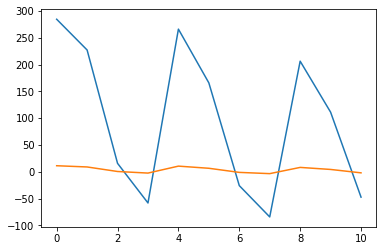

  6%|▌         | 11/200 [00:15<04:25,  1.41s/it]

nnodes: 10, seq_range 150 epoch: 11


  6%|▌         | 12/200 [00:17<05:39,  1.81s/it]

loss: -122.453, val_loss -4.898
nnodes: 1, seq_range 2 epoch: 12


  6%|▋         | 13/200 [00:18<04:42,  1.51s/it]

loss: 151.831, val_loss 6.073
nnodes: 2, seq_range 20 epoch: 13


  7%|▋         | 14/200 [00:19<04:10,  1.35s/it]

loss: 82.173, val_loss 3.287
nnodes: 5, seq_range 150 epoch: 14


  8%|▊         | 15/200 [00:21<04:17,  1.39s/it]

loss: -57.404, val_loss -2.296
nnodes: 10, seq_range 150 epoch: 15


  8%|▊         | 16/200 [00:23<05:19,  1.74s/it]

loss: -142.460, val_loss -5.698
nnodes: 1, seq_range 2 epoch: 16


  8%|▊         | 17/200 [00:24<04:26,  1.45s/it]

loss: 133.873, val_loss 5.355
nnodes: 2, seq_range 20 epoch: 17


  9%|▉         | 18/200 [00:25<04:00,  1.32s/it]

loss: 63.964, val_loss 2.559
nnodes: 5, seq_range 150 epoch: 18


 10%|▉         | 19/200 [00:26<04:09,  1.38s/it]

loss: -83.644, val_loss -3.346
nnodes: 10, seq_range 150 epoch: 19


 10%|█         | 20/200 [00:29<05:11,  1.73s/it]

loss: -155.153, val_loss -6.206
nnodes: 1, seq_range 2 epoch: 20
loss: 110.326, val_loss 4.413


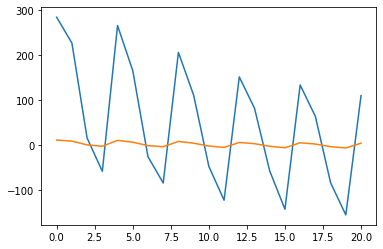

 10%|█         | 21/200 [00:30<04:21,  1.46s/it]

nnodes: 2, seq_range 20 epoch: 21


 11%|█         | 22/200 [00:31<03:50,  1.30s/it]

loss: 45.187, val_loss 1.807
nnodes: 5, seq_range 150 epoch: 22


 12%|█▏        | 23/200 [00:32<04:01,  1.36s/it]

loss: -103.041, val_loss -4.122
nnodes: 10, seq_range 150 epoch: 23


 12%|█▏        | 24/200 [00:35<05:30,  1.88s/it]

loss: -167.025, val_loss -6.681
nnodes: 1, seq_range 2 epoch: 24


 12%|█▎        | 25/200 [00:36<04:31,  1.55s/it]

loss: 83.091, val_loss 3.324
nnodes: 2, seq_range 20 epoch: 25


 13%|█▎        | 26/200 [00:37<03:58,  1.37s/it]

loss: 28.448, val_loss 1.138
nnodes: 5, seq_range 150 epoch: 26


 14%|█▎        | 27/200 [00:39<04:02,  1.40s/it]

loss: -118.052, val_loss -4.722
nnodes: 10, seq_range 150 epoch: 27


 14%|█▍        | 28/200 [00:41<04:59,  1.74s/it]

loss: -174.128, val_loss -6.965
nnodes: 1, seq_range 2 epoch: 28


 14%|█▍        | 29/200 [00:42<04:06,  1.44s/it]

loss: 79.217, val_loss 3.169
nnodes: 2, seq_range 20 epoch: 29


 15%|█▌        | 30/200 [00:43<03:37,  1.28s/it]

loss: 20.448, val_loss 0.818
nnodes: 5, seq_range 150 epoch: 30
loss: -126.593, val_loss -5.064


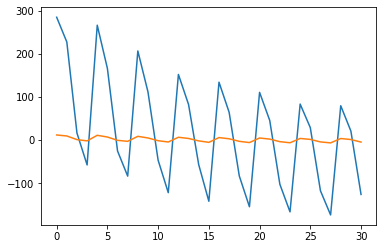

 16%|█▌        | 31/200 [00:44<03:50,  1.37s/it]

nnodes: 10, seq_range 150 epoch: 31


 16%|█▌        | 32/200 [00:47<04:47,  1.71s/it]

loss: -184.321, val_loss -7.373
nnodes: 1, seq_range 2 epoch: 32


 16%|█▋        | 33/200 [00:48<03:58,  1.43s/it]

loss: 66.042, val_loss 2.642
nnodes: 2, seq_range 20 epoch: 33


 17%|█▋        | 34/200 [00:49<03:33,  1.29s/it]

loss: 10.632, val_loss 0.425
nnodes: 5, seq_range 150 epoch: 34


 18%|█▊        | 35/200 [00:50<03:50,  1.39s/it]

loss: -136.818, val_loss -5.473
nnodes: 10, seq_range 150 epoch: 35


 18%|█▊        | 36/200 [00:53<04:46,  1.75s/it]

loss: -192.801, val_loss -7.712
nnodes: 1, seq_range 2 epoch: 36


 18%|█▊        | 37/200 [00:53<03:55,  1.45s/it]

loss: 57.942, val_loss 2.318
nnodes: 2, seq_range 20 epoch: 37


 19%|█▉        | 38/200 [00:54<03:29,  1.29s/it]

loss: 3.340, val_loss 0.134
nnodes: 5, seq_range 150 epoch: 38


 20%|█▉        | 39/200 [00:56<03:38,  1.35s/it]

loss: -143.664, val_loss -5.747
nnodes: 10, seq_range 150 epoch: 39


 20%|██        | 40/200 [00:58<04:31,  1.70s/it]

loss: -199.403, val_loss -7.976
nnodes: 1, seq_range 2 epoch: 40
loss: 55.755, val_loss 2.230


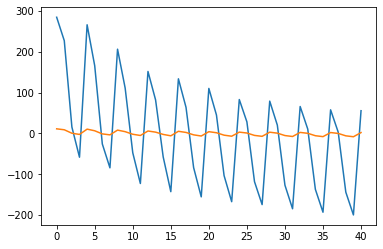

 20%|██        | 41/200 [00:59<03:50,  1.45s/it]

nnodes: 2, seq_range 20 epoch: 41


 21%|██        | 42/200 [01:00<03:23,  1.29s/it]

loss: -1.649, val_loss -0.066
nnodes: 5, seq_range 150 epoch: 42


 22%|██▏       | 43/200 [01:02<03:31,  1.35s/it]

loss: -152.157, val_loss -6.086
nnodes: 10, seq_range 150 epoch: 43


 22%|██▏       | 44/200 [01:04<04:26,  1.71s/it]

loss: -208.127, val_loss -8.325
nnodes: 1, seq_range 2 epoch: 44


 22%|██▎       | 45/200 [01:05<03:40,  1.42s/it]

loss: 45.436, val_loss 1.817
nnodes: 2, seq_range 20 epoch: 45


 23%|██▎       | 46/200 [01:06<03:16,  1.28s/it]

loss: -9.715, val_loss -0.389
nnodes: 5, seq_range 150 epoch: 46


 24%|██▎       | 47/200 [01:07<03:23,  1.33s/it]

loss: -159.156, val_loss -6.366
nnodes: 10, seq_range 150 epoch: 47


 24%|██▍       | 48/200 [01:10<04:18,  1.70s/it]

loss: -213.494, val_loss -8.540
nnodes: 1, seq_range 2 epoch: 48


 24%|██▍       | 49/200 [01:11<03:32,  1.41s/it]

loss: 44.247, val_loss 1.770
nnodes: 2, seq_range 20 epoch: 49


 25%|██▌       | 50/200 [01:12<03:13,  1.29s/it]

loss: -14.224, val_loss -0.569
nnodes: 5, seq_range 150 epoch: 50
loss: -165.012, val_loss -6.600


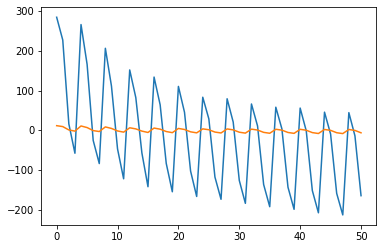

 26%|██▌       | 51/200 [01:13<03:31,  1.42s/it]

nnodes: 10, seq_range 150 epoch: 51


 26%|██▌       | 52/200 [01:16<04:20,  1.76s/it]

loss: -220.705, val_loss -8.828
nnodes: 1, seq_range 2 epoch: 52


 26%|██▋       | 53/200 [01:17<03:34,  1.46s/it]

loss: 35.479, val_loss 1.419
nnodes: 2, seq_range 20 epoch: 53


 27%|██▋       | 54/200 [01:18<03:10,  1.30s/it]

loss: -20.292, val_loss -0.812
nnodes: 5, seq_range 150 epoch: 54


 28%|██▊       | 55/200 [01:19<03:17,  1.36s/it]

loss: -170.716, val_loss -6.829
nnodes: 10, seq_range 150 epoch: 55


 28%|██▊       | 56/200 [01:22<04:05,  1.71s/it]

loss: -225.016, val_loss -9.001
nnodes: 1, seq_range 2 epoch: 56


 28%|██▊       | 57/200 [01:22<03:24,  1.43s/it]

loss: 37.524, val_loss 1.501
nnodes: 2, seq_range 20 epoch: 57


 29%|██▉       | 58/200 [01:23<03:01,  1.28s/it]

loss: -23.164, val_loss -0.927
nnodes: 5, seq_range 150 epoch: 58


 30%|██▉       | 59/200 [01:25<03:08,  1.34s/it]

loss: -177.334, val_loss -7.093
nnodes: 10, seq_range 150 epoch: 59


 30%|███       | 60/200 [01:27<04:01,  1.73s/it]

loss: -231.824, val_loss -9.273
nnodes: 1, seq_range 2 epoch: 60
loss: 27.860, val_loss 1.114
setting lr to 0.001


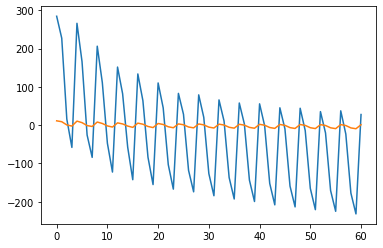

 30%|███       | 61/200 [01:28<03:26,  1.48s/it]

nnodes: 2, seq_range 20 epoch: 61


 31%|███       | 62/200 [01:29<03:05,  1.34s/it]

loss: -28.052, val_loss -1.122
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 62


 32%|███▏      | 63/200 [01:31<03:18,  1.45s/it]

loss: -180.668, val_loss -7.227
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 63


 32%|███▏      | 64/200 [01:34<04:09,  1.84s/it]

loss: -235.455, val_loss -9.418
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 64


 32%|███▎      | 65/200 [01:35<03:25,  1.53s/it]

loss: 30.633, val_loss 1.225
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 65


 33%|███▎      | 66/200 [01:36<03:04,  1.38s/it]

loss: -30.075, val_loss -1.203
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 66


 34%|███▎      | 67/200 [01:37<03:11,  1.44s/it]

loss: -188.108, val_loss -7.524
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 67


 34%|███▍      | 68/200 [01:40<04:01,  1.83s/it]

loss: -241.704, val_loss -9.668
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 68


 34%|███▍      | 69/200 [01:41<03:19,  1.53s/it]

loss: 19.306, val_loss 0.772
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 69


 35%|███▌      | 70/200 [01:42<02:59,  1.38s/it]

loss: -36.267, val_loss -1.451
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 70
loss: -193.940, val_loss -7.758
setting lr to 0.001


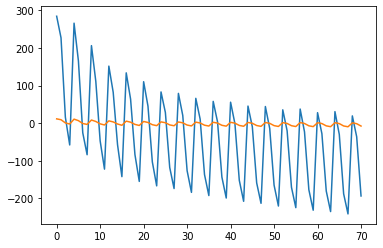

 36%|███▌      | 71/200 [01:44<03:08,  1.46s/it]

nnodes: 10, seq_range 150 epoch: 71


 36%|███▌      | 72/200 [01:46<03:51,  1.81s/it]

loss: -246.389, val_loss -9.856
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 72


 36%|███▋      | 73/200 [01:47<03:11,  1.51s/it]

loss: 16.354, val_loss 0.654
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 73


 37%|███▋      | 74/200 [01:48<02:52,  1.37s/it]

loss: -39.635, val_loss -1.585
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 74


 38%|███▊      | 75/200 [01:50<02:59,  1.44s/it]

loss: -196.434, val_loss -7.857
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 75


 38%|███▊      | 76/200 [01:52<03:41,  1.78s/it]

loss: -249.525, val_loss -9.981
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 76


 38%|███▊      | 77/200 [01:53<03:01,  1.48s/it]

loss: 14.310, val_loss 0.572
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 77


 39%|███▉      | 78/200 [01:54<02:41,  1.32s/it]

loss: -42.116, val_loss -1.685
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 78


 40%|███▉      | 79/200 [01:55<02:48,  1.39s/it]

loss: -200.531, val_loss -8.021
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 79


 40%|████      | 80/200 [01:58<03:27,  1.73s/it]

loss: -253.317, val_loss -10.133
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 80
loss: 9.446, val_loss 0.378
setting lr to 0.001


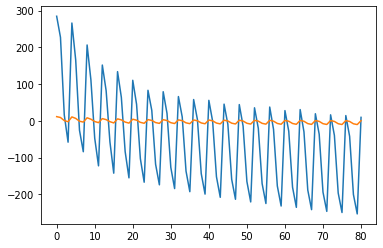

 40%|████      | 81/200 [01:59<02:53,  1.46s/it]

nnodes: 2, seq_range 20 epoch: 81


 41%|████      | 82/200 [02:00<02:37,  1.34s/it]

loss: -46.283, val_loss -1.851
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 82


 42%|████▏     | 83/200 [02:02<02:48,  1.44s/it]

loss: -204.188, val_loss -8.168
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 83


 42%|████▏     | 84/200 [02:04<03:34,  1.85s/it]

loss: -256.988, val_loss -10.280
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 84


 42%|████▎     | 85/200 [02:05<02:57,  1.55s/it]

loss: 6.081, val_loss 0.243
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 85


 43%|████▎     | 86/200 [02:06<02:37,  1.38s/it]

loss: -49.263, val_loss -1.971
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 86


 44%|████▎     | 87/200 [02:08<02:51,  1.52s/it]

loss: -206.667, val_loss -8.267
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 87


 44%|████▍     | 88/200 [02:11<03:31,  1.89s/it]

loss: -259.867, val_loss -10.395
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 88


 44%|████▍     | 89/200 [02:12<02:53,  1.56s/it]

loss: 4.312, val_loss 0.172
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 89


 45%|████▌     | 90/200 [02:13<02:33,  1.40s/it]

loss: -51.809, val_loss -2.072
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 90
loss: -209.808, val_loss -8.392
setting lr to 0.001


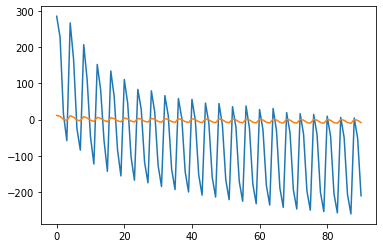

 46%|████▌     | 91/200 [02:14<02:42,  1.49s/it]

nnodes: 10, seq_range 150 epoch: 91


 46%|████▌     | 92/200 [02:17<03:15,  1.81s/it]

loss: -262.898, val_loss -10.516
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 92


 46%|████▋     | 93/200 [02:18<02:41,  1.51s/it]

loss: 1.144, val_loss 0.046
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 93


 47%|████▋     | 94/200 [02:19<02:23,  1.35s/it]

loss: -54.496, val_loss -2.180
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 94


 48%|████▊     | 95/200 [02:20<02:29,  1.42s/it]

loss: -212.742, val_loss -8.510
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 95


 48%|████▊     | 96/200 [02:23<03:11,  1.84s/it]

loss: -265.690, val_loss -10.628
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 96


 48%|████▊     | 97/200 [02:24<02:37,  1.53s/it]

loss: -1.170, val_loss -0.047
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 97


 49%|████▉     | 98/200 [02:25<02:20,  1.38s/it]

loss: -56.904, val_loss -2.276
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 98


 50%|████▉     | 99/200 [02:27<02:27,  1.46s/it]

loss: -215.566, val_loss -8.623
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 99


 50%|█████     | 100/200 [02:29<03:05,  1.86s/it]

loss: -268.356, val_loss -10.734
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 100
loss: -3.714, val_loss -0.149
setting lr to 0.001


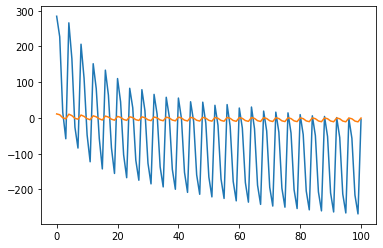

 50%|█████     | 101/200 [02:30<02:36,  1.58s/it]

nnodes: 2, seq_range 20 epoch: 101


 51%|█████     | 102/200 [02:31<02:17,  1.41s/it]

loss: -59.289, val_loss -2.372
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 102


 52%|█████▏    | 103/200 [02:33<02:22,  1.47s/it]

loss: -218.296, val_loss -8.732
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 103


 52%|█████▏    | 104/200 [02:36<02:55,  1.83s/it]

loss: -271.074, val_loss -10.843
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 104


 52%|█████▎    | 105/200 [02:36<02:23,  1.51s/it]

loss: -6.866, val_loss -0.275
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 105


 53%|█████▎    | 106/200 [02:37<02:07,  1.36s/it]

loss: -61.725, val_loss -2.469
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 106


 54%|█████▎    | 107/200 [02:39<02:14,  1.45s/it]

loss: -220.705, val_loss -8.828
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 107


 54%|█████▍    | 108/200 [02:42<02:49,  1.84s/it]

loss: -273.764, val_loss -10.951
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 108


 55%|█████▍    | 109/200 [02:43<02:19,  1.53s/it]

loss: -9.743, val_loss -0.390
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 109


 55%|█████▌    | 110/200 [02:44<02:03,  1.38s/it]

loss: -63.995, val_loss -2.560
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 110
loss: -223.091, val_loss -8.924
setting lr to 0.001


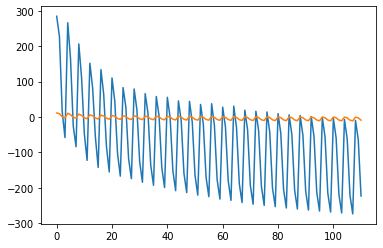

 56%|█████▌    | 111/200 [02:45<02:12,  1.49s/it]

nnodes: 10, seq_range 150 epoch: 111


 56%|█████▌    | 112/200 [02:48<02:41,  1.84s/it]

loss: -276.458, val_loss -11.058
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 112


 56%|█████▋    | 113/200 [02:49<02:14,  1.54s/it]

loss: -12.397, val_loss -0.496
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 113


 57%|█████▋    | 114/200 [02:50<01:58,  1.38s/it]

loss: -65.965, val_loss -2.639
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 114


 57%|█████▊    | 115/200 [02:51<02:01,  1.43s/it]

loss: -225.176, val_loss -9.007
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 115


 58%|█████▊    | 116/200 [02:54<02:28,  1.76s/it]

loss: -278.798, val_loss -11.152
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 116


 58%|█████▊    | 117/200 [02:55<02:01,  1.46s/it]

loss: -14.601, val_loss -0.584
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 117


 59%|█████▉    | 118/200 [02:56<01:49,  1.34s/it]

loss: -67.352, val_loss -2.694
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 118


 60%|█████▉    | 119/200 [02:57<01:52,  1.39s/it]

loss: -226.790, val_loss -9.072
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 119


 60%|██████    | 120/200 [03:00<02:21,  1.77s/it]

loss: -280.828, val_loss -11.233
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 120
loss: -17.598, val_loss -0.704
setting lr to 0.001


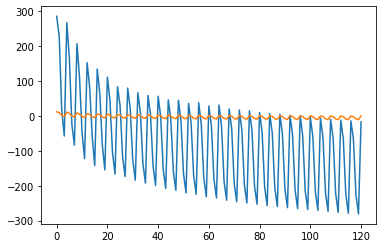

 60%|██████    | 121/200 [03:01<01:58,  1.50s/it]

nnodes: 2, seq_range 20 epoch: 121


 61%|██████    | 122/200 [03:02<01:44,  1.33s/it]

loss: -68.660, val_loss -2.746
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 122


 62%|██████▏   | 123/200 [03:03<01:47,  1.39s/it]

loss: -228.660, val_loss -9.146
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 123


 62%|██████▏   | 124/200 [03:06<02:10,  1.72s/it]

loss: -282.664, val_loss -11.307
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 124


 62%|██████▎   | 125/200 [03:06<01:47,  1.43s/it]

loss: -20.627, val_loss -0.825
setting lr to 0.001
nnodes: 2, seq_range 20 epoch: 125


 63%|██████▎   | 126/200 [03:07<01:35,  1.29s/it]

loss: -69.650, val_loss -2.786
setting lr to 0.001
nnodes: 5, seq_range 150 epoch: 126


 64%|██████▎   | 127/200 [03:09<01:39,  1.37s/it]

loss: -229.549, val_loss -9.182
setting lr to 0.001
nnodes: 10, seq_range 150 epoch: 127


 64%|██████▍   | 128/200 [03:11<02:03,  1.71s/it]

loss: -284.265, val_loss -11.371
setting lr to 0.001
nnodes: 1, seq_range 2 epoch: 128


 64%|██████▍   | 129/200 [03:12<01:41,  1.43s/it]

loss: -23.146, val_loss -0.926
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 129


 65%|██████▌   | 130/200 [03:13<01:30,  1.29s/it]

loss: -70.397, val_loss -2.816
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 130
loss: -230.837, val_loss -9.233
setting lr to 0.000


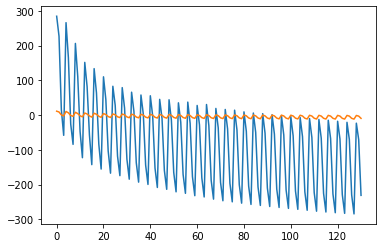

 66%|██████▌   | 131/200 [03:15<01:38,  1.42s/it]

nnodes: 10, seq_range 150 epoch: 131


 66%|██████▌   | 132/200 [03:18<02:00,  1.78s/it]

loss: -286.535, val_loss -11.461
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 132


 66%|██████▋   | 133/200 [03:18<01:38,  1.47s/it]

loss: -24.145, val_loss -0.966
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 133


 67%|██████▋   | 134/200 [03:19<01:26,  1.31s/it]

loss: -72.093, val_loss -2.884
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 134


 68%|██████▊   | 135/200 [03:21<01:30,  1.40s/it]

loss: -233.363, val_loss -9.335
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 135


 68%|██████▊   | 136/200 [03:24<01:54,  1.78s/it]

loss: -288.924, val_loss -11.557
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 136


 68%|██████▊   | 137/200 [03:24<01:33,  1.49s/it]

loss: -24.398, val_loss -0.976
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 137


 69%|██████▉   | 138/200 [03:25<01:23,  1.35s/it]

loss: -74.509, val_loss -2.980
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 138


 70%|██████▉   | 139/200 [03:27<01:26,  1.43s/it]

loss: -235.640, val_loss -9.426
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 139


 70%|███████   | 140/200 [03:30<01:47,  1.80s/it]

loss: -290.531, val_loss -11.621
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 140
loss: -26.021, val_loss -1.041
setting lr to 0.000


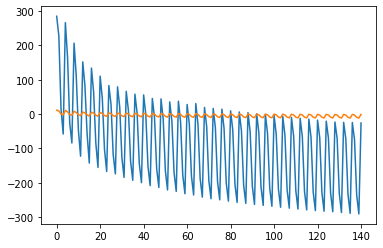

 70%|███████   | 141/200 [03:31<01:30,  1.53s/it]

nnodes: 2, seq_range 20 epoch: 141


 71%|███████   | 142/200 [03:32<01:19,  1.38s/it]

loss: -75.850, val_loss -3.034
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 142


 72%|███████▏  | 143/200 [03:33<01:21,  1.44s/it]

loss: -236.493, val_loss -9.460
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 143


 72%|███████▏  | 144/200 [03:36<01:41,  1.82s/it]

loss: -291.696, val_loss -11.668
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 144


 72%|███████▎  | 145/200 [03:37<01:22,  1.50s/it]

loss: -27.727, val_loss -1.109
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 145


 73%|███████▎  | 146/200 [03:38<01:12,  1.34s/it]

loss: -76.714, val_loss -3.069
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 146


 74%|███████▎  | 147/200 [03:39<01:13,  1.39s/it]

loss: -236.936, val_loss -9.477
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 147


 74%|███████▍  | 148/200 [03:42<01:33,  1.80s/it]

loss: -293.072, val_loss -11.723
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 148


 74%|███████▍  | 149/200 [03:43<01:15,  1.49s/it]

loss: -28.449, val_loss -1.138
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 149


 75%|███████▌  | 150/200 [03:44<01:06,  1.33s/it]

loss: -77.655, val_loss -3.106
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 150
loss: -238.948, val_loss -9.558
setting lr to 0.000


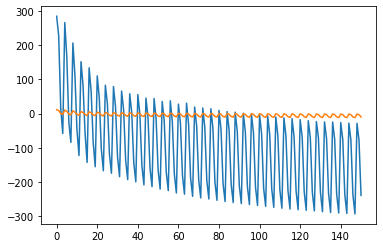

 76%|███████▌  | 151/200 [03:45<01:09,  1.41s/it]

nnodes: 10, seq_range 150 epoch: 151


 76%|███████▌  | 152/200 [03:48<01:24,  1.76s/it]

loss: -294.728, val_loss -11.789
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 152


 76%|███████▋  | 153/200 [03:48<01:09,  1.47s/it]

loss: -29.831, val_loss -1.193
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 153


 77%|███████▋  | 154/200 [03:49<01:00,  1.32s/it]

loss: -78.825, val_loss -3.153
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 154


 78%|███████▊  | 155/200 [03:51<01:03,  1.41s/it]

loss: -239.996, val_loss -9.600
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 155


 78%|███████▊  | 156/200 [03:54<01:19,  1.80s/it]

loss: -296.416, val_loss -11.857
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 156


 78%|███████▊  | 157/200 [03:55<01:04,  1.49s/it]

loss: -29.464, val_loss -1.179
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 157


 79%|███████▉  | 158/200 [03:56<00:56,  1.34s/it]

loss: -80.227, val_loss -3.209
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 158


 80%|███████▉  | 159/200 [03:57<00:57,  1.41s/it]

loss: -242.310, val_loss -9.692
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 159


 80%|████████  | 160/200 [04:00<01:11,  1.78s/it]

loss: -297.859, val_loss -11.914
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 160
loss: -31.902, val_loss -1.276
setting lr to 0.000


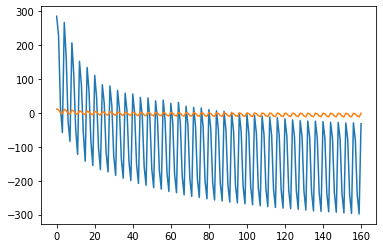

 80%|████████  | 161/200 [04:01<00:59,  1.53s/it]

nnodes: 2, seq_range 20 epoch: 161


 81%|████████  | 162/200 [04:02<00:52,  1.38s/it]

loss: -80.909, val_loss -3.236
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 162


 82%|████████▏ | 163/200 [04:03<00:54,  1.47s/it]

loss: -242.639, val_loss -9.706
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 163


 82%|████████▏ | 164/200 [04:06<01:07,  1.86s/it]

loss: -299.239, val_loss -11.970
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 164


 82%|████████▎ | 165/200 [04:07<00:54,  1.55s/it]

loss: -32.525, val_loss -1.301
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 165


 83%|████████▎ | 166/200 [04:08<00:47,  1.40s/it]

loss: -82.093, val_loss -3.284
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 166


 84%|████████▎ | 167/200 [04:10<00:48,  1.47s/it]

loss: -245.228, val_loss -9.809
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 167


 84%|████████▍ | 168/200 [04:12<00:59,  1.85s/it]

loss: -299.983, val_loss -11.999
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 168


 84%|████████▍ | 169/200 [04:13<00:47,  1.55s/it]

loss: -33.613, val_loss -1.345
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 169


 85%|████████▌ | 170/200 [04:14<00:41,  1.39s/it]

loss: -81.430, val_loss -3.257
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 170
loss: -245.261, val_loss -9.810
setting lr to 0.000


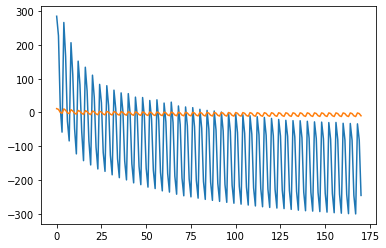

 86%|████████▌ | 171/200 [04:16<00:43,  1.49s/it]

nnodes: 10, seq_range 150 epoch: 171


 86%|████████▌ | 172/200 [04:19<00:51,  1.83s/it]

loss: -299.172, val_loss -11.967
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 172


 86%|████████▋ | 173/200 [04:20<00:41,  1.53s/it]

loss: -33.350, val_loss -1.334
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 173


 87%|████████▋ | 174/200 [04:21<00:35,  1.38s/it]

loss: -81.740, val_loss -3.270
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 174


 88%|████████▊ | 175/200 [04:22<00:36,  1.46s/it]

loss: -247.838, val_loss -9.914
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 175


 88%|████████▊ | 176/200 [04:25<00:43,  1.81s/it]

loss: -297.221, val_loss -11.889
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 176


 88%|████████▊ | 177/200 [04:26<00:34,  1.50s/it]

loss: -35.127, val_loss -1.405
setting lr to 0.000
nnodes: 2, seq_range 20 epoch: 177


 89%|████████▉ | 178/200 [04:27<00:29,  1.33s/it]

loss: -81.685, val_loss -3.267
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 178


 90%|████████▉ | 179/200 [04:28<00:29,  1.40s/it]

loss: -249.780, val_loss -9.991
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 179


 90%|█████████ | 180/200 [04:31<00:34,  1.75s/it]

loss: -299.984, val_loss -11.999
setting lr to 0.000
nnodes: 1, seq_range 2 epoch: 180
loss: -37.543, val_loss -1.502
setting lr to 0.000


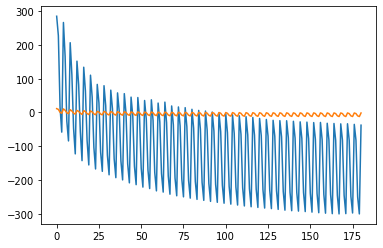

 90%|█████████ | 181/200 [04:32<00:28,  1.48s/it]

nnodes: 2, seq_range 20 epoch: 181


 91%|█████████ | 182/200 [04:32<00:23,  1.33s/it]

loss: -83.103, val_loss -3.324
setting lr to 0.000
nnodes: 5, seq_range 150 epoch: 182


 92%|█████████▏| 183/200 [04:34<00:23,  1.38s/it]

loss: -251.212, val_loss -10.048
setting lr to 0.000
nnodes: 10, seq_range 150 epoch: 183


 92%|█████████▏| 183/200 [04:36<00:25,  1.51s/it]


KeyboardInterrupt: 

In [421]:

n_epochs = 200
nnodes_schedule = [1,2,5,10]
nseq_range_schedule = [2,20,150,150]
min_spacing_schedule = [1,5,5,5]
iterations_schedule = [3]
nbatch = 300
val_pct = 0.2 # percentage of sequence samples from the **seen ** experiments used as a validation set.
fixed_spacing_indices = False

# n_epochs = 200
# nbatch  = 600

# edge_feat_size = 1
# val_pct = 0.1
# fixed_spacing_indices = False;
# nnodes_schedule =     [1,2,5,10] #[10,10,1,2,5]#2,2,3,3]#,1,2,2,1,1,3,3]
# # nseq_range_schedule = [200,100,150];
# min_spacing_schedule =[10];

# nnodes_schedule =     [1,2,5,10] #[10,10,1,2,5]#2,2,3,3]#,1,2,2,1,1,3,3]
# nseq_range_schedule = [200,150,100];
# min_spacing_schedule =[10];


for i in tqdm(range(n_epochs)):
    np.random.seed(42); 
    epoch = i
    
    # This makes sure that I always get different training and validation sets (there can still be some overlap but training should work ok)
    nnodes      = nnodes_schedule[i%len(nnodes_schedule)]
    nseq_range  = nseq_range_schedule[i%len(nseq_range_schedule)]
    min_spacing = min_spacing_schedule[i%len(min_spacing_schedule)]
    
    if (nnodes * min_spacing) > nseq_range:
        min_spacing = 10
        nseq_range = nnodes * min_spacing+10
        
    print("nnodes: %i, seq_range %i epoch: %i"%(nnodes, nseq_range, i))
    graph_curr_data_multibatch, y_curr_data_multibatch = get_multi_batch_rnn(
        nbatch, source_ds=True,
        nnodes=nnodes,
        min_spacing = min_spacing,
        nseq_range = nseq_range,
        fixed_spacing_indices=fixed_spacing_indices, 
        edge_feat_size = edge_feat_size);
    
    loss_epoch = 0;
    val_loss_epoch = 0;
    
    for single_minibatch, y_curr_data_batch in zip(graph_curr_data_multibatch, y_curr_data_multibatch):
        with tf.GradientTape() as tape:
            graph_curr, dt_curr = single_minibatch;
            
            prob_out = rnn_gamma_model((dt_curr,graph_curr))
            all_weights = rnn_gamma_model.weights#[*gn.weights(), *graph_indep.weights()];
            loss_vals = -prob_out.log_prob(y_curr_data_batch[np.newaxis].T) #* (1.2 - y_curr[np.newaxis].T)**2
            train_loss = loss_vals[0:int(nbatch*(1-val_pct))];

            grads = tape.gradient(train_loss, all_weights)
            all_weights_filt = all_weights
            #all_weights_filt = [all_weights[k] for k in range(len(grads)) if grads[k] is not None]
            grads_filt = [grads[k] for k in range(len(grads)) if grads[k] is not None]
            opt.apply_gradients(zip(grads_filt, all_weights_filt))
            loss_epoch += train_loss/len(y_curr_data)

            
       
        val_loss_epoch += tf.reduce_mean(loss_vals[int(-nbatch*(val_pct)):])
        
    loss_log.append_loss(np.sum(loss_epoch.numpy()))
    loss_log.append_val_loss(np.sum(val_loss_epoch.numpy()))
    loss_log.print()
    lr_scheduler.on_epoch_end(epoch)
    if early_stop.on_epoch_end(epoch):
        break
        
    if epoch%10 == 0:
        pplot.plot(loss_log.loss_history['loss'])
        pplot.plot(loss_log.loss_history['val_loss'])
        pplot.show()
        

In [422]:
dt_curr.shape,graph_curr.shape
rnn_gamma_model.inputs

[<KerasTensor: shape=(None, None, 1) dtype=float32 (created by layer 'input_48')>,
 <KerasTensor: shape=(None, None, None, 1) dtype=float32 (created by layer 'input_49')>]

In [423]:
b = get_multi_batch_local(nbatch, source_ds=True,nnodes=nnodes,
                                min_spacing = min_spacing,
                                nseq_range = nseq_range,
                                fixed_spacing_indices=fixed_spacing_indices)




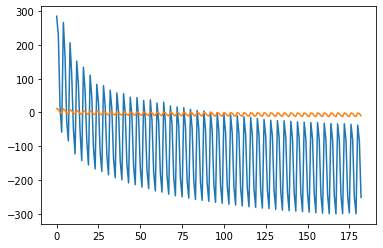

In [424]:
pplot.plot(loss_log.loss_history['loss'])
pplot.plot(loss_log.loss_history['val_loss'])


10


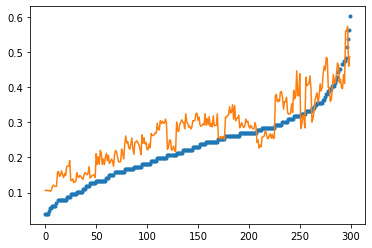

In [425]:
#loss_vals = -prob_out.log_prob(y_curr[np.newaxis].T)
#loss_vals
print(nnodes)

ids_sort = np.argsort(y_curr_data_batch.flatten());
pplot.plot(y_curr_data_batch.flatten()[ids_sort],'.')
pplot.plot(prob_out.mean().numpy().flatten()[ids_sort])

In [426]:

#prob_out.mean()
#ids_sort

In [427]:
cell.h_cnn.weights

[<tf.Variable 'conv_fcnA/kernel:0' shape=(1, 1, 50) dtype=float32, numpy=
 array([[[ 0.26325998, -0.2287203 , -0.35243344, -0.29594   ,
          -0.26930183,  0.14958613, -0.16386624, -0.1199127 ,
           0.36858246, -0.23281047,  0.25926295,  0.17736469,
           0.12259396, -0.14501181, -0.315028  , -0.29175723,
          -0.30112344,  0.2885491 , -0.1412332 ,  0.14158946,
          -0.03811378,  0.2645199 ,  0.18234895,  0.04462052,
           0.08720254,  0.18132347,  0.26157188,  0.2536538 ,
          -0.15299398, -0.23831658, -0.14403945, -0.260861  ,
           0.36588633,  0.12110982,  0.25411442,  0.30251995,
          -0.29639417,  0.1544289 ,  0.31227994,  0.35541564,
          -0.11914836, -0.12391763,  0.01583234,  0.29569167,
           0.33208072, -0.02638824, -0.08230921,  0.07369341,
          -0.14120652, -0.23284964]]], dtype=float32)>,
 <tf.Variable 'conv_fcnB/kernel:0' shape=(3, 50, 18) dtype=float32, numpy=
 array([[[ 0.11275011, -0.08092046, -0.02089053, ..

In [428]:
ee = 1
nnodes = 1
nsampled = 10
graphs, y_times = get_graph_data(ee, X_ = X, eid_oh_ = eid_oh, yrem_norm_ = yrem_norm, n_sampled_graphs = nsampled, nnodes=nnodes)
rnn_dat = graph_dat_to_rnn_dat(graphs,1)

In [429]:
res = rnn_gamma_model((rnn_dat[1], rnn_dat[0]))


In [430]:
normalization_factor_time = DATASET.normalization_factor_time

In [431]:
csfont = {'fontname':'Times New Roman','fontsize' : 24}

def plot_experiments(experiments_to_plot, eval_mode = "safe",
                     nseq_len = None, xaxis_sample = False, max_time = 2.5):
    #training = inds_exp_source
    nsampled = 500

    pplot.figure(figsize = (15,int(10/3*len(experiments_to_plot))), dpi = 300)
    nnodes_list = [1,5,10]#,3,5]
    if nseq_len is None:
        nseq_len = [100,100,100]
    
    minspacing= [5,5,5]
    gnsteps  = [ 3,3,3]
    
    normalization_factor_time = 1;#fic.normalization_factor_time #femto_dataset.normalization_factor_time
    plt_data = [];
    kk = 0;
    return_values = [] 
    for exp_index , ee in enumerate(experiments_to_plot):
        for nnodes, gnsteps_,nseq_,minspacing_ in zip(nnodes_list, gnsteps, nseq_len, minspacing):
                        
            graphs, y_times = get_graph_data(ee, X_ = fic_test.X, eid_oh_ = fic_test.eid_oh,
                                             yrem_norm_ = fic_test.yrem_norm, n_sampled_graphs = nsampled,
                                             nnodes=nnodes, fixed_spacing_indices=False, min_spacing=minspacing_,
                                             nseq_range=nseq_)
#             probs = gn_tot.eval_graphnets(graphs,gnsteps_,eval_mode = eval_mode)
            d = graph_dat_to_rnn_dat(graphs,1)
            dat_ = [d[1] ,d[0]]
            
            probs = rnn_gamma_model(dat_)

            if max_time is None:
                max_time = np.max(y)*1.5

            ids_sorted = np.argsort(y_times.flatten())
            time_grid= np.linspace(0,max_time,102)
            tohours = lambda x : x 
            
            #time_grid = np.linspace(np.min(y_times),3.5, 150);
                #ind_exp = 0;

            e_y = probs.mean()
            p_y = probs.prob(time_grid).numpy().T
            
            y_times_sorted = y_times[ids_sorted].flatten();
            return_values.append((y_times_sorted))
            
            y_times_sorted_unnorm = y_times_sorted * normalization_factor_time;
            pplot.subplot( len(experiments_to_plot),len(nnodes_list), kk+1)
            q90 = np.quantile(probs.sample(1000).numpy(),[0.05,0.95],0)[:,:,0].T[ids_sorted]
            
            
            
            if xaxis_sample:
                assert(0)
                
            else:
                pplot.pcolor(tohours(y_times_sorted_unnorm.flatten()), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted].squeeze()**0.5, cmap = "gray")
                pplot.plot(tohours(y_times_sorted_unnorm.flatten()), tohours(y_times_sorted  *normalization_factor_time), linewidth = 7)
                
            #pplot.plot(tohours(y_times_sorted_unnorm),tohours(q90*femto_dataset.normalization_factor_time),'C1-.', alpha = 0.4)
            #pplot.plot(e_y.numpy()[ids_sorted]*normalization_factor_time,'C1',label = "$E[t_f]$",alpha = 0.5)<3
            
            #pplot.plot(tohours(y_times_sorted_unnorm).flatten(),tohours(q90*fic.normalization_factor_time).squeeze(),'C1-.', alpha = 0.4)
            pplot.plot(tohours(y_times_sorted_unnorm),tohours(q90*normalization_factor_time),'C1-.', alpha = 0.4)
            
            pplot.ylim(0,tohours(max_time))
            if nnodes == 1:
                #pplot.ylabel("Experiment %i/%s\nPredicted RUL[h]"%(ee,femto_dataset.file_suffix[ee]), fontsize = 20)
                pplot.ylabel("Experiment %s\nPredicted RUL[h]"%(ee), **csfont)
                
            #pplot.xlabel("Actual time to failure [s]")
            
            #pplot.ylabel("Predicted time to failure [s]")
            
            #pplot.xlabel("Predicted RUL[h]",fontsize = 20)

            nll = -np.mean(probs.log_prob(y_times[np.newaxis].T))
            
            parameters = {'nnodes' : nnodes, 'gnsteps' : gnsteps_ ,  'minspacing_' : minspacing}
            density_plot = {'density_plot' : (y_times_sorted_unnorm, time_grid * normalization_factor_time, p_y[:, ids_sorted]**0.5), 
                            'actual_ttf_line' : (y_times_sorted_unnorm, y_times_sorted  *normalization_factor_time), 
                            'eval_parameters' : parameters}
            quantiles = {'quantiles' : (y_times_sorted_unnorm,q90*fic.normalization_factor_time)}
            loss = {'experiment' : ee, 'nll' : nll}
            plt_data.append({'loss' : loss,'quantiles' : quantiles , 'density_plot' : density_plot, 'parameters'  : parameters})
            
            
            if exp_index == 0:
                title = "Obs.:%i\nNLL:%2.3f"%(nnodes,nll)
            else:
                title = "NLL:%2.3f"%(nll)
            
            if exp_index == (len(experiments_to_plot)-1):
                pplot.xlabel("Actual RUL[h]", **csfont)
            
            pplot.title(title, **csfont)
            kk+=1
    pplot.subplots_adjust(hspace = 0.30, wspace = 0.30)
    return return_values
            

<ipython-input-431-088ac71423f8>:59: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm.flatten()), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted].squeeze()**0.5, cmap = "gray")
<ipython-input-431-088ac71423f8>:59: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pplot.pcolor(tohours(y_times_sorted_unnorm.flatten()), tohours(time_grid*normalization_factor_time), p_y[:,ids_sorted].squeeze()**0.5, cmap = "gra

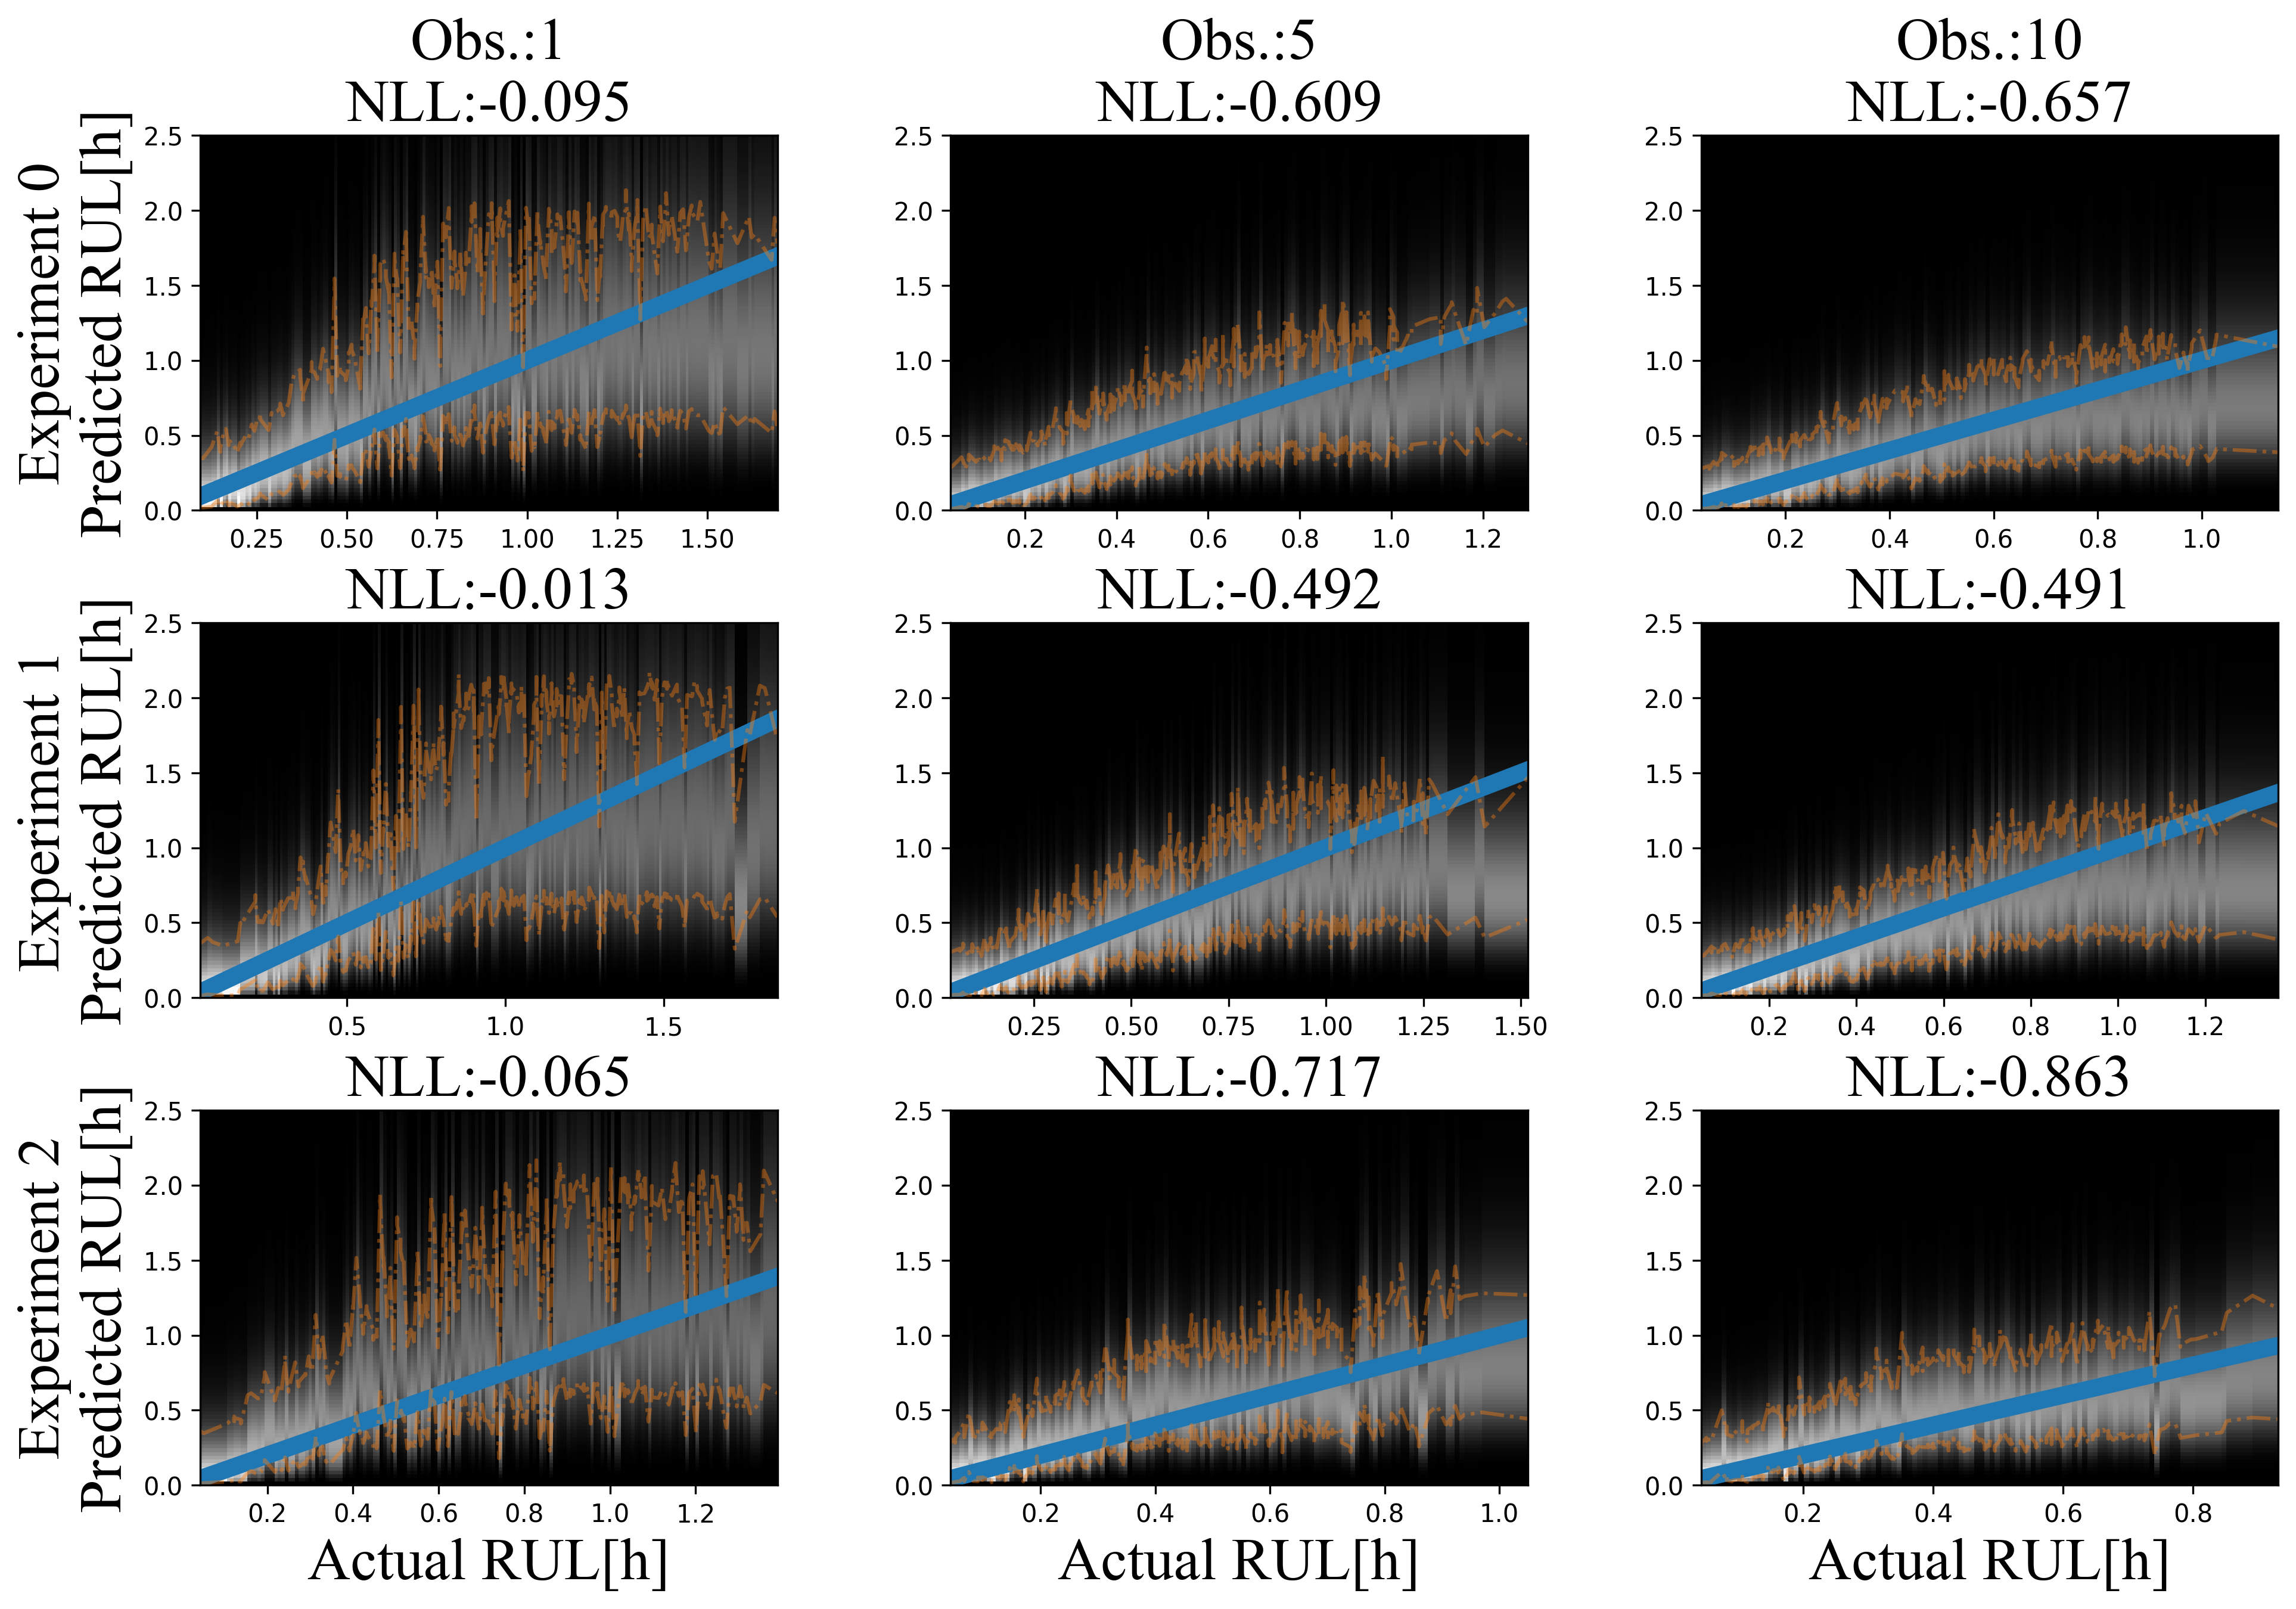

In [432]:
vv = plot_experiments([0,1,2])
pplot.savefig("fictitious_LSTM-tCNN.png")
#!cp fictitious_GNN-tCNN.png /home/charilaos/current/paper

In [435]:
!cp fictitious_LSTM-tCNN.png /home/charilaos/Workspace/ETH_WindmilRepositories/GraphNetCNN-paper/figures/
!cp fictitious_LSTM-tCNN.png /home/charilaos/Workspace/ETH_WindmilRepositories/GraphNetCNN-paper/to_mssp/figures/